In [2]:
from matplotlib import pyplot as plt 
%matplotlib inline
import glob
import cv2
import numpy as np
from collections import Counter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [3]:
dataset_path="./python/images_background/"
languages = [path.split("/")[-1] for path in glob.glob(dataset_path+"*")]

In [4]:
all_alphabets = {language:[cv2.cvtColor(cv2.imread(image),cv2.COLOR_RGB2GRAY) for image in glob.glob(dataset_path+language+"/*/*")]\
                                                                       for language in languages }

In [5]:
lengthes = np.cumsum([len(all_alphabets[key]) for key in all_alphabets])  

In [6]:
all_images =  np.vstack([np.array(all_alphabets[key]) for key in all_alphabets])

In [7]:
all_images.shape

(19280, 105, 105)

In [8]:
def generator(features,batch_size):
 
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 2, 105, 105))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            indecies= np.random.choice(len(all_images),2)
            #print(indecies)
            image1,image2 = all_images[indecies[0]],all_images[indecies[1]]
            batch_features[i] = (image1,image2)
            distance1,distance2 = lengthes-indecies[0],lengthes-indecies[1]
            insame_class = np.argmax(distance1>0) == np.argmax(distance2>0)
            batch_labels[i] = insame_class
        yield batch_features, batch_labels

In [27]:
def plot_batch(batch_size,images,labels,columns=2):
    plt.subplots(figsize=(10,10))
    plt.subplots_adjust(top=2)
    index = 1
    for i, ims in enumerate(images):
    
        for im in ims:
            plt.subplot(batch_size, columns, index)
            plt.imshow(im,cmap='bone')
            index+=1
            
        plt.title(int(labels[i]),fontsize=14)

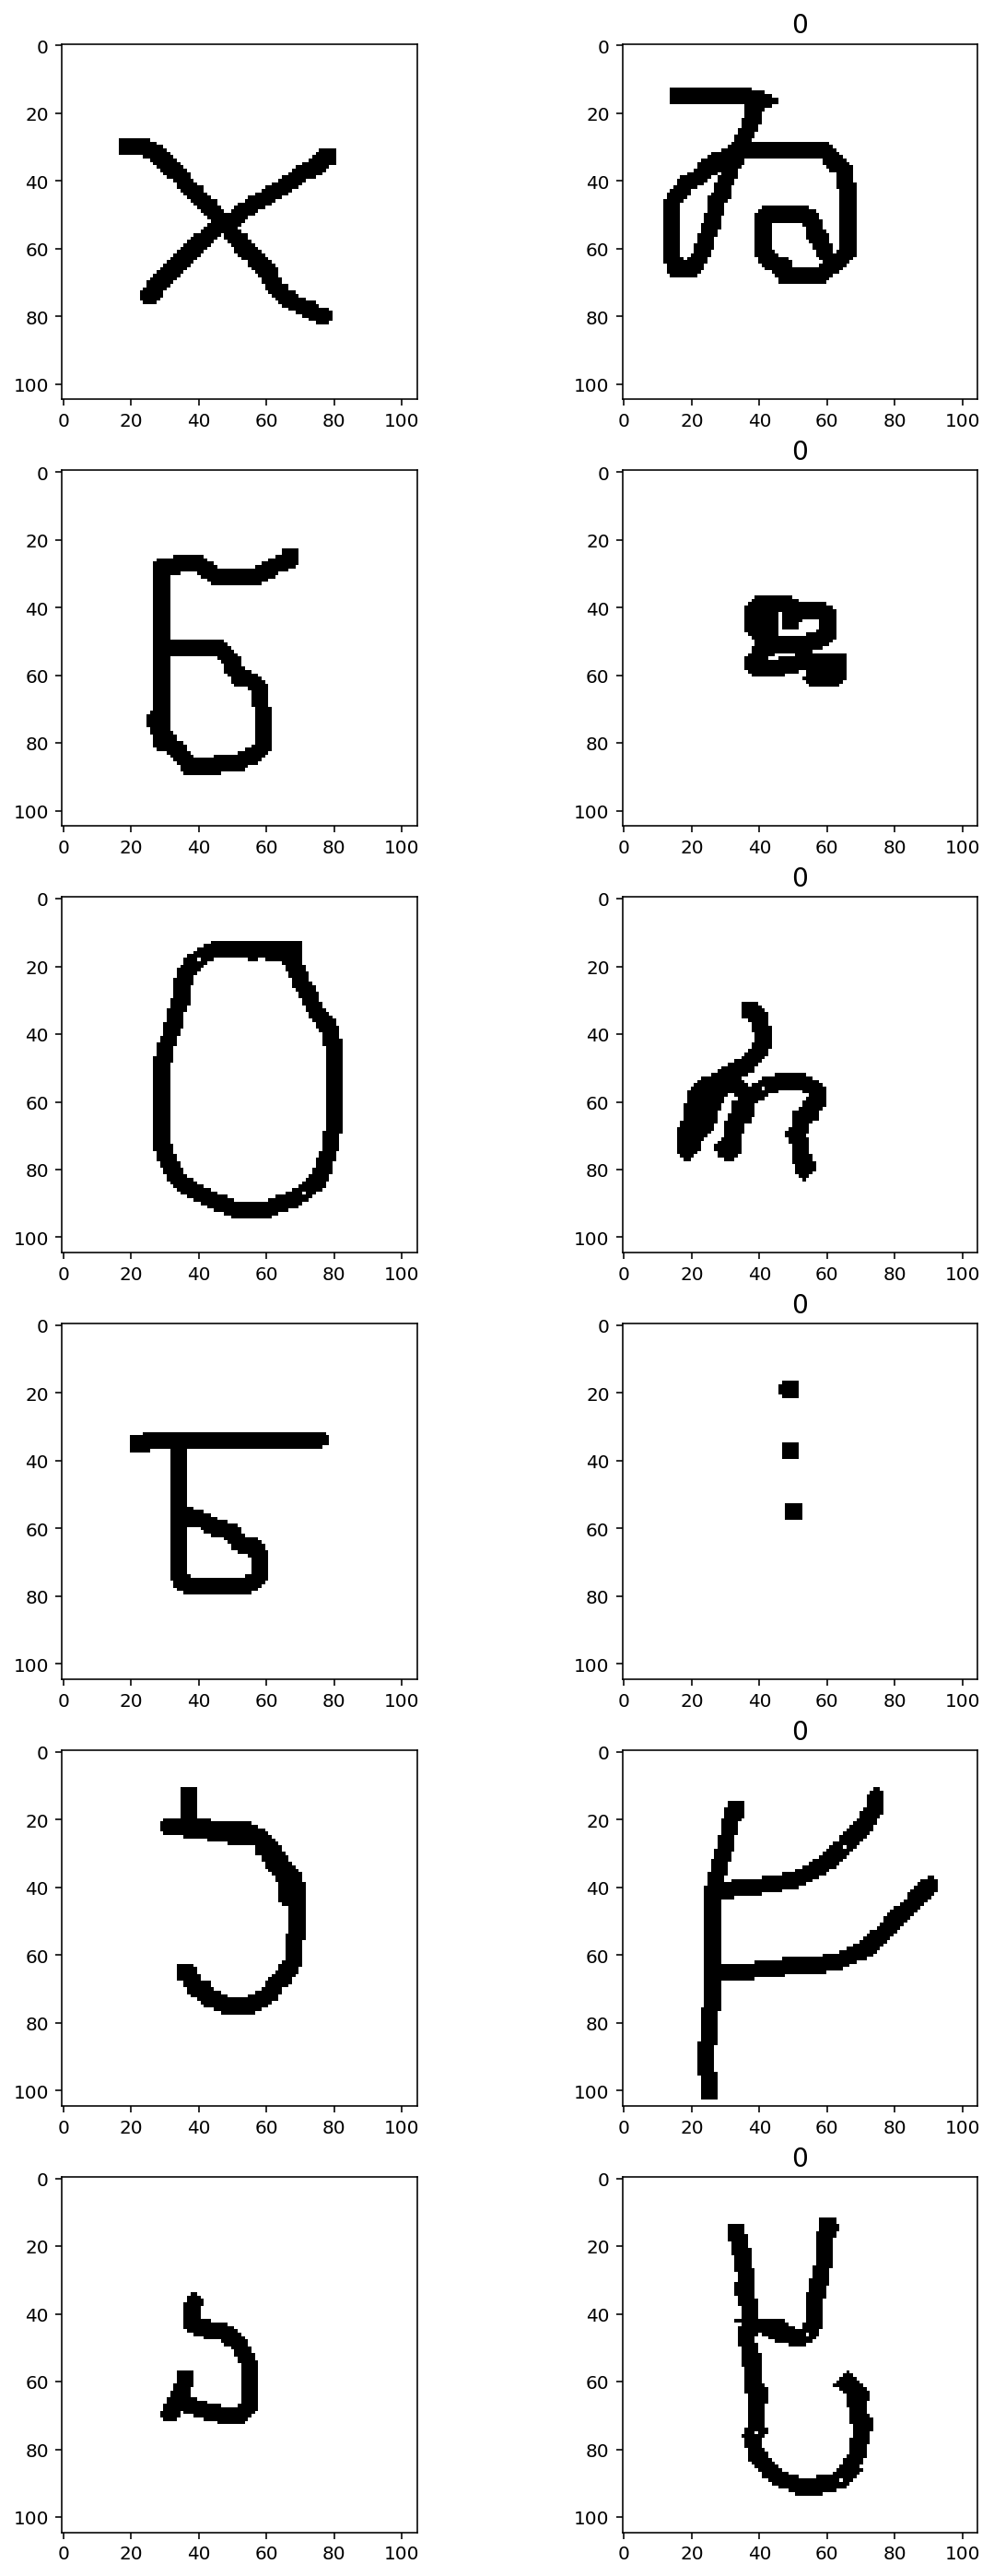

In [28]:
batch_size = 6
images,labels = next(generator(all_images,batch_size))
plot_batch(6,images,labels)

In [69]:
import random
def flip(p):
    # bigger p = less TRUE
    # True - in same class
    return random.random() < p
def semi_balanced_generator(features,batch_size,distribution,validation):
    # Returns a generator across data.
    # Returns array of size (batch_size,2,105,105,1)
    # Returns array of labels. 1 - same alphabet, 0 - different alphabets
    batch_features = np.zeros((batch_size, 2,105, 105,1))
    batch_labels = np.zeros((batch_size,1))
    macro_dict = all_evaluation_alphabets if validation else all_alphabets
    lengthes = np.insert(np.cumsum([len(macro_dict[key]) for key in macro_dict]),0,0)
    
    while True:

        for i in range(batch_size):
            not_insame_class = True
            if flip(distribution):
                while not_insame_class:
                    indecies= np.random.choice(len(features),2)
                    not_insame_class = np.argmax(lengthes-indecies[0]>0) != np.argmax(lengthes-indecies[1]>0)

            else:
                
                first = np.searchsorted(lengthes,np.random.randint(1,len(features)))
                indecies = np.zeros(2)
                while abs(indecies[0]-indecies[1]) < 20 : indecies = np.random.choice(range(lengthes[first-1],lengthes[first]),2)
                
            batch_labels[i] = not_insame_class    
            image1,image2 = features[indecies[0]].reshape(105,105,1),features[indecies[1]].reshape(105,105,1)
            batch_features[i] = (image1,image2)
            
        yield batch_features, batch_labels

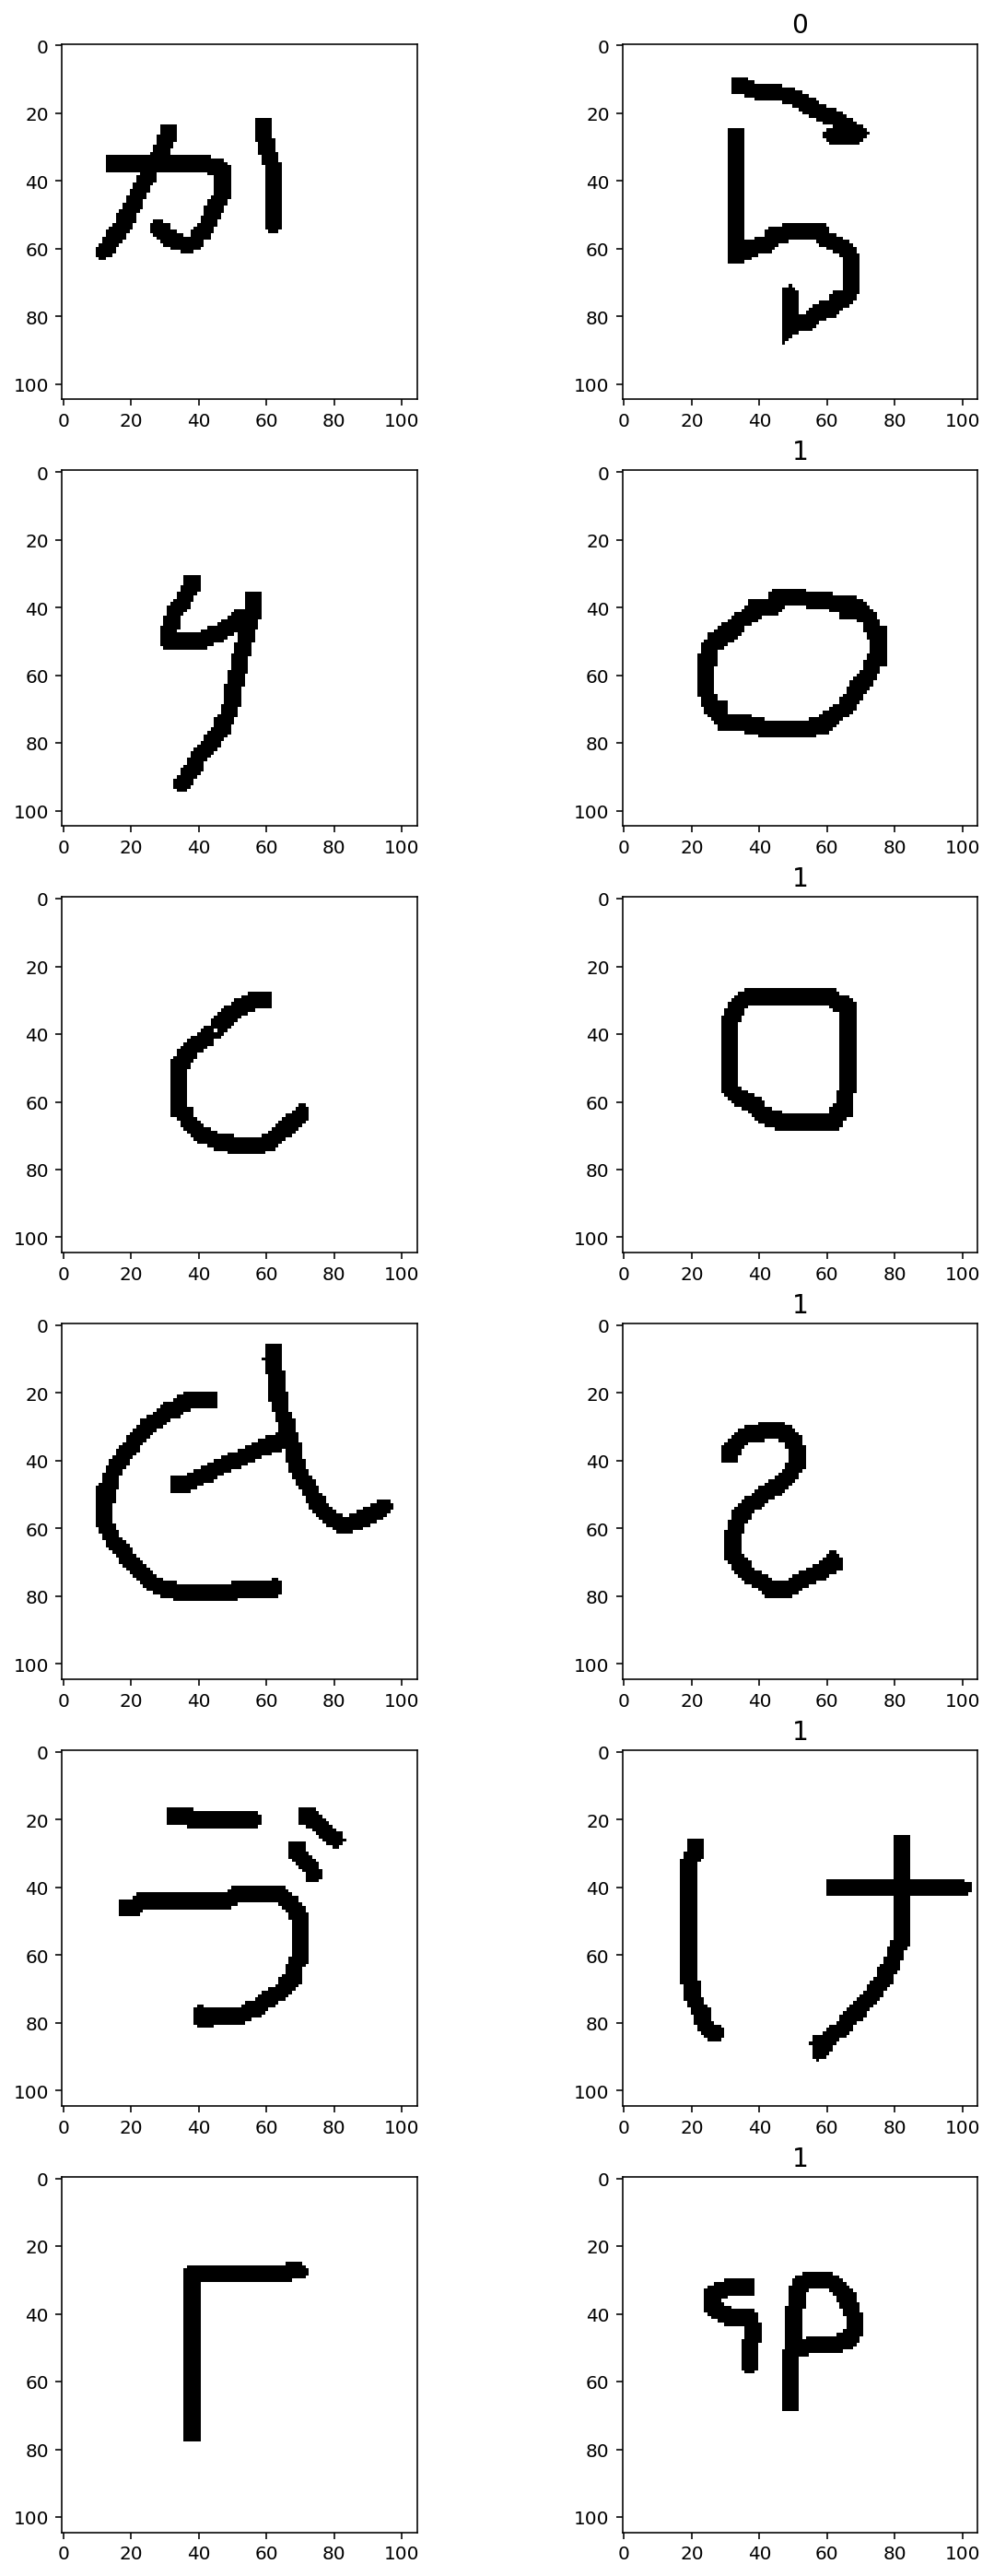

In [70]:
batch_size = 6
images,labels = next(semi_balanced_generator(all_images,batch_size,0.5,False))
images=images.reshape((6,2,105,105))
plot_batch(batch_size,images,labels)